# Отчет 
## Графовые нейронные сети на базе слов для решения задачи Page Layout Analysis

**Задача**: Кратко сформулировать, какую проблему решает новая архитектура.

**Гипотеза**: Какие предположения лежат в основе нового подхода?

**Ожидания**: Какие улучшения предполагаются (скорость, точность, устойчивость и т. д.)?


Нужно где-то сказать про GLAM, и что она решает две задачи.

### Метрика качества
- F1 @ WordIoU [0.5, 0.95]
- mAP @ IoU [0.50:0.95]
- time

$$WordIoU = \frac{WordI}{WordU}$$

$WordI$-число слов в пересекающейся области

$WordU$-число слов в объединенной области

# Текущая SOTA на данных метриках (200 из val publaynet) 

|model|F1 WordIoU 0.50/0.95 | mAP @IoU [0.50:0.95] | time (file/sec)|
|-----|---------------------|----------------------|----------------|
| VGT |0.9985/0.8613        | 0.8713               |0.5792


# Локальные эксперименты
Локальные эксперименты проводятся на 1000 документах из train и нужны для качетсвенной оценки подходов

Тестирование серий происходит на 50 файлах

In [10]:
import re
import matplotlib.pyplot as plt

def extract_metrics_from_file(file_content):
    """
    Извлекает метрики F1 (IoU=0.50 и IoU=0.95), mAP и время из текста файла.
    
    Args:
        file_content (str): Содержимое файла с метриками.
    
    Returns:
        dict: Словарь с извлеченными метриками.
            {
                "F1_0.50": float,
                "F1_0.95": float,
                "mAP": float,
                "time": float
            }
    """
    metrics = {
        "F1_0.50": None,
        "F1_0.95": None,
        "mAP": None,
        "time": None
    }
    
    # Извлекаем F1 (IoU=0.50)
    f1_50_match = re.search(r"F1 \(IoU=0\.50\):\s+([0-9.]+)", file_content)
    if f1_50_match:
        metrics["F1_0.50"] = float(f1_50_match.group(1))
    
    # Извлекаем F1 (IoU=0.95)
    f1_95_match = re.search(r"F1 \(IoU=0\.95\):\s+([0-9.]+)", file_content)
    if f1_95_match:
        metrics["F1_0.95"] = float(f1_95_match.group(1))
    
    # Извлекаем mAP
    map_match = re.search(r"mAP@IoU\[0\.50:0\.95\]\s*=\s*([0-9.]+)", file_content)
    if map_match:
        metrics["mAP"] = float(map_match.group(1))
    
    # Извлекаем время
    time_match = re.search(r"mean time:\s+([0-9.]+)\s*sec", file_content)
    if time_match:
        metrics["time"] = float(time_match.group(1))
    
    return metrics

def read_res_test(header, name):
    with open(f'{header}/{name}/test_result.txt') as f:
         return extract_metrics_from_file(f.read())

### Exp 1. (balans)
Число классов в данных не равномерное. Это относится как к классификации, так и сегментации. Первый эксперимент направлен на выявление значимости балансировки.



In [29]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_no', '02_yes', '03_heuristics']:
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_01_balans', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_no	0.0742115	0.02597403	0.00330477
02_yes	0.43432203	0.24152542	0.05744661
03_heur	0.4773022	0.23605707	0.05522135


### Exp 2. (Edge loss + Node loss)
Исходная модель направлена на решение сразу двух задач. Из архитектуры видно, что задача классификации решается раньше сегментации. Поэтому возникает вопрос, а если решать задачу только сегментации, необходимо ли включать в функцию потерь составляющую для классификации и если да, то в каком соотношение с loss для сегментации.

$$Loss=\alpha Loss_{node} + (1-\alpha) Loss_{edge}$$

01_005
{'F1_0.50': 0.33846154, 'F1_0.95': 0.14945055, 'mAP': 0.03773091, 'time': 3.2572}
02_025
{'F1_0.50': 0.4601227, 'F1_0.95': 0.26175869, 'mAP': 0.060892, 'time': 3.2087}
03_050
{'F1_0.50': 0.49888641, 'F1_0.95': 0.26948775, 'mAP': 0.06764539, 'time': 3.2513}
04_075
{'F1_0.50': 0.46884273, 'F1_0.95': 0.2611276, 'mAP': 0.05822105, 'time': 3.1955}
05_095
{'F1_0.50': 0.47363718, 'F1_0.95': 0.27524576, 'mAP': 0.06179598, 'time': 3.1927}


Text(0.5, 0, 'a')

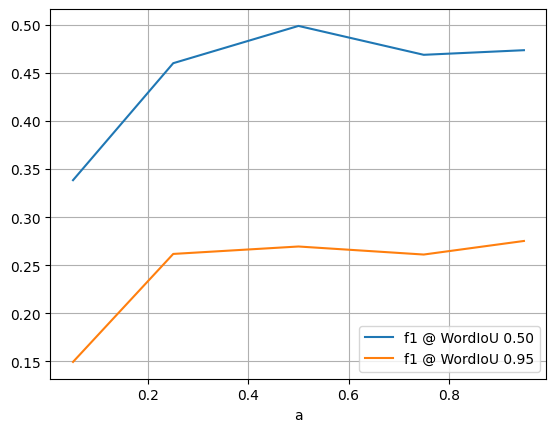

In [20]:

rez = []
t = [0.05, 0.25, 0.50, 0.75, 0.95]
for obj in ['01_005', '02_025', '03_050', '04_075', '05_095']:
    print(obj)
    r = read_res_test('exp_02_complex_loss', obj)
    print(r)
    rez.append(r)

f1_50 = [r['F1_0.50'] for r in rez]
f1_95 = [r['F1_0.95'] for r in rez]

plt.grid()
plt.plot(t, f1_50, label="f1 @ WordIoU 0.50")
plt.plot(t, f1_95, label="f1 @ WordIoU 0.95")
plt.legend()
plt.xlabel('a')

### Exp 3. (count Tag)
Число слоев может отличаться, поскольку слов в документе на много больше, чем строк.

In [30]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_2', '02_3', '03_4']:
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_03_countTag', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_2	0.45488029	0.25966851	0.05943854
02_3	0.46349206	0.24761905	0.06030691
03_4	0.44549763	0.25592417	0.05827855


### Exp 4. (k-глубина)
В работе у слоев tag стоит k=3, варианты 1-6.

In [34]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_1', '02_2', '03_3']: #, '04_4', '05_5', '06_6']:
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_04_kTag', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_1	0.49533679	0.27564767	0.06838913
02_2	0.45540399	0.27072403	0.05975045
03_3	0.44635193	0.24034335	0.05098085
